In [1]:
import pyqg
import pyqg_generative.tools.operators as op
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pyqg_parameterization_benchmarks.coarsening_ops as ppb
from pyqg_generative.tools.spectral_tools import *
from pyqg_generative.tools.operators import ave_lev
%load_ext autoreload
%autoreload 3

/ext3/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [61]:
def error(x,y):
    return float(np.mean(np.abs(x-y)))

In [62]:
X = np.random.randn(64,64)
Y = np.ones((64,64))
q = xr.open_dataset('/scratch/pp2681/pyqg_generative/highres/online_eddy.nc').isel(run=0,time=-1,lev=0).q.values.astype('float64')

nc=32, error=0.12220008453162971
nc=16, error=0.03370748009322489
nc=8, error=0.00341109038952231
nc=4, error=0.001023908610104195


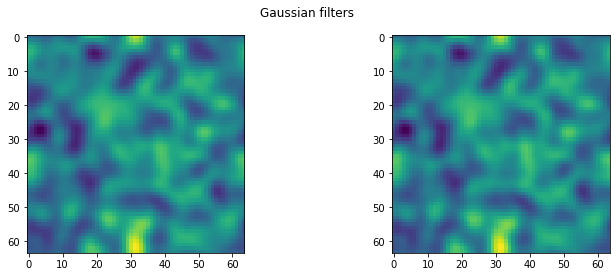

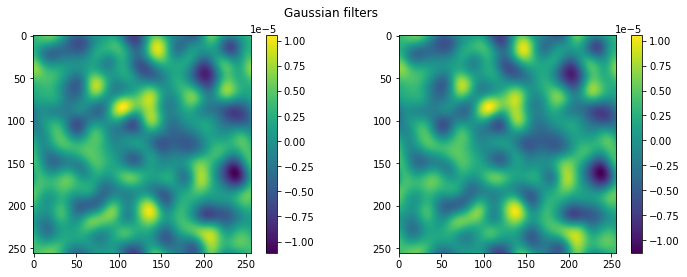

In [63]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(op.gauss_filter(X, 8))
plt.subplot(1,2,2); plt.imshow(op.gcm_filter(X, 8))
plt.suptitle('Gaussian filters')
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(op.gauss_filter(q, 8)); plt.colorbar()
plt.subplot(1,2,2); plt.imshow(op.gcm_filter(q, 8)); plt.colorbar()
plt.suptitle('Gaussian filters')

for nc in [32, 16, 8, 4]:
    print(f'nc={nc}, error={error(op.gauss_filter(X, nc), op.gcm_filter(X, nc))}')

Text(0.5, 0.98, 'Model filter')

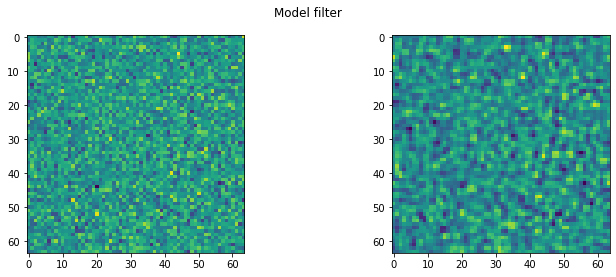

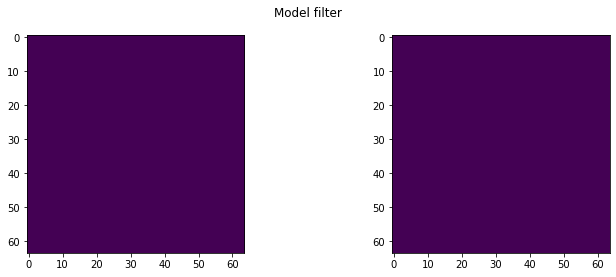

In [64]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(X)
plt.subplot(1,2,2); plt.imshow(op.model_filter(X))
plt.suptitle('Model filter')
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(Y)
plt.subplot(1,2,2); plt.imshow(op.model_filter(Y))
plt.suptitle('Model filter')

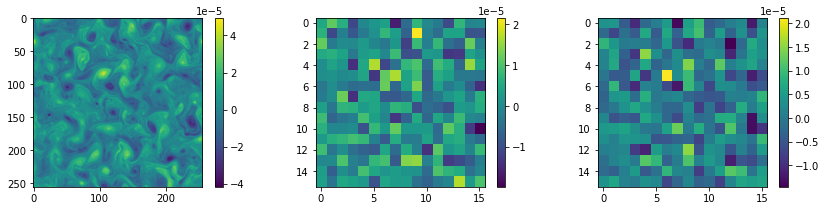

In [65]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.imshow(q); plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(op.cut_off(q,16)); plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(op.coarsegrain(q,16)); plt.colorbar()
plt.tight_layout()

# Commutation errors

In [66]:
error(op.gauss_filter(op.cut_off(X, 16), 8), op.cut_off(op.gauss_filter(X, 8), 16)) / np.mean(np.abs(X))

3.270787152946804e-17

In [67]:
error(op.gcm_filter(op.coarsegrain(X, 16), 8), op.coarsegrain(op.gcm_filter(X, 8), 16)) / np.mean(np.abs(X))

0.06297510008076851

In [68]:
error(op.gcm_filter(op.gauss_filter(X, 16), 8), op.gauss_filter(op.gcm_filter(X, 8), 16)) / np.mean(np.abs(X))

4.096316513054585e-17

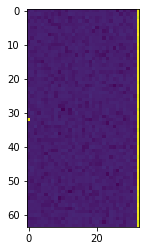

In [69]:
plt.imshow(np.log(np.abs(np.fft.rfftn(op.clean_2h(X)-X))))

# Try different formats

In [70]:
ds = xr.open_dataset('/scratch/pp2681/pyqg_generative/highres/online_eddy.nc')

In [71]:
op1 = op.gauss_filter

In [72]:
op1(np.stack((X,X)), nc=32)[0]

array([[-0.15894246, -0.24021163, -0.12628415, ..., -0.12800297,
         0.11080641,  0.94826517],
       [-0.27623108,  0.32347347,  0.26555665, ...,  0.10778679,
         0.20695878,  0.23543828],
       [ 0.09043442,  0.58076932,  0.44051929, ...,  0.21521444,
         0.51577147,  0.14248539],
       ...,
       [-0.54762743, -0.35027563,  0.60273105, ..., -0.50383165,
        -0.21857708, -0.20360332],
       [-0.82145031, -0.08506327, -0.04493295, ..., -0.42478311,
        -0.67436714, -1.01670292],
       [-0.98891154, -0.62898119, -0.27708195, ..., -0.06015177,
         0.12351608, -0.14685272]])

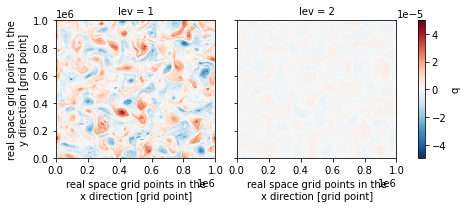

In [73]:
op.model_filter(ds.q.isel(run=0,time=-1), nc=32).plot(col='lev')


# Operators

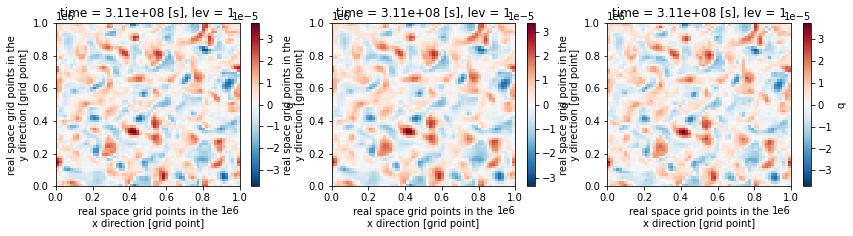

In [74]:
q = ds.q.isel(run=0, time=-1,lev=0)
plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
op.Operator1(q, nc=64).plot()
plt.subplot(1,3,2)
op.Operator2(q, nc=64).plot()
plt.subplot(1,3,3)
op.Operator3(q, nc=64).plot()

# Comparison of operators to Andrew ones. Note the error only due to removing 2h harmonics!

In [75]:
m = pyqg.QGModel(nx=256, log_level=0)
q = ds.q.isel(run=0, time=-1).astype('float64')
q = q - q.mean(('x','y'))
m.q = q.values

In [85]:
def plot_error(Andrew, Me, qf, labels=('Andrew', 'Me')):
    print(f'mean Andrew = {float(Andrew.mean())}, mean Me = {float(Me.mean())}')
    try:
        print(f'Relative error = {float(((Andrew-Me)**2).mean() / (Andrew**2).mean())}')
    except:
        pass
    plt.figure(figsize=(16,3))
    plt.subplot(1,5,1)
    plt.imshow(Andrew); plt.colorbar(); plt.title(labels[0])
    plt.subplot(1,5,2)
    plt.imshow(Me); plt.colorbar(); plt.title(labels[1])
    try:
        err = Andrew-Me
        plt.subplot(1,5,3)
        plt.imshow(err); plt.colorbar(); plt.title('Difference')
        plt.subplot(1,5,4)
        plt.imshow(np.abs(np.fft.rfftn(err)))
        plt.title('Spectrum of error')
    except:
        pass
    plt.subplot(1,5,5)
    _m = pyqg.QGModel(nx=Andrew.shape[0])
    try:
        error_spec = calc_ispec(_m,np.real(np.fft.rfftn(qf) * np.conj(np.fft.rfftn(err))), averaging=False, truncate=False)
        plt.semilogx(error_spec[0], np.abs(error_spec[1]), label='Error')
    except:
        pass
    try:
        Andrew_spec = calc_ispec(_m,np.real(np.fft.rfftn(qf) * np.conj(np.fft.rfftn(Andrew))), averaging=False, truncate=False)
        Me_spec = calc_ispec(_m,np.real(np.fft.rfftn(qf) * np.conj(np.fft.rfftn(Me))), averaging=False, truncate=False)
        plt.semilogx(Andrew_spec[0], np.abs(Andrew_spec[1]), label=labels[0], color='y')
        plt.semilogx(Me_spec[0], np.abs(Me_spec[1]), label=labels[1], ls='--', color='k')
    except:
        pass
    plt.legend()
    plt.title('Cospectrum of error')
    return err

def plot_operators(opAndrew, opMe):
    Andrew = opAndrew(m, 64).m2.q[1]
    Me = opMe(q, 64)[1]
    qf = op.Operator3(q, 64)[1]
    return plot_error(Andrew, Me, qf)

INFO:  Logger initialized


mean Andrew = 3.3087224502121107e-23, mean Me = 2.6469779601696886e-23
Relative error = 1.5824995764754692e-31


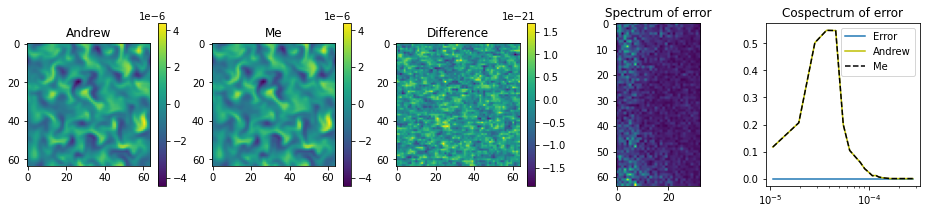

In [86]:
err1 = plot_operators(ppb.Operator1, op.Operator1);

INFO:  Logger initialized


mean Andrew = 3.3087224502121107e-23, mean Me = 1.9852334701272664e-23
Relative error = 1.4698989550692419e-31


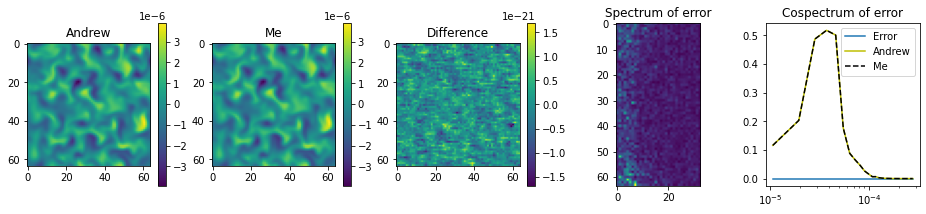

In [87]:
err2 = plot_operators(ppb.Operator2, op.Operator2);

INFO:  Logger initialized


mean Andrew = 3.3087224502121107e-23, mean Me = 3.3087224502121107e-23
Relative error = 0.0


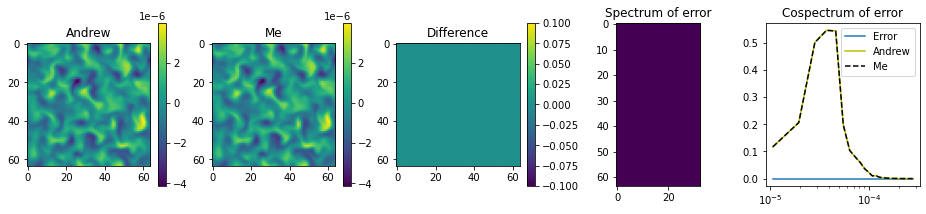

In [88]:
err3 = plot_operators(ppb.Operator3, op.Operator3)

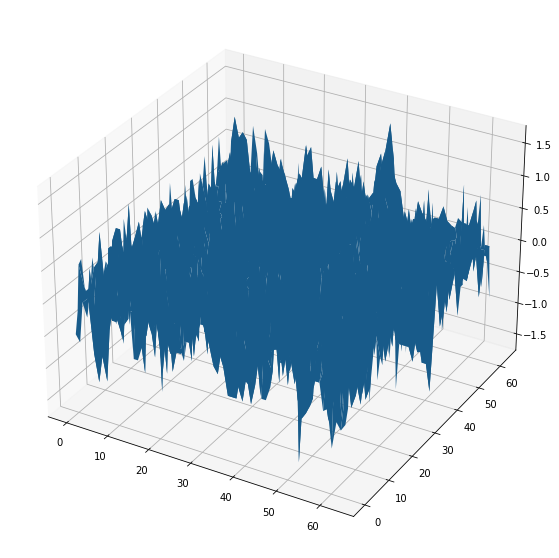

In [89]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(*np.meshgrid(range(64),range(64)), err2)

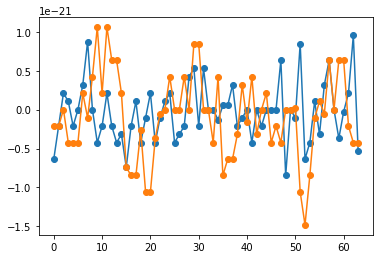

In [90]:
plt.plot(err2[:,1], marker='o')
plt.plot(err2[1,:], marker='o')

# Computation of subgrid flux

In [91]:
def plot_fluxes(opAndrew, opMe):
    Andrew = -opAndrew(m, 64).subgrid_fluxes('q')[0][0]
    Me = op.PV_subgrid_flux(q.values, 64, opMe, {})[0][0]
    qf = op.Operator1(q, 64)[0]
    return plot_error(Andrew, Me, qf)

INFO:  Logger initialized


mean Andrew = -2.7590811513156112e-14, mean Me = -2.759081152344417e-14
Relative error = 9.157419968635079e-30


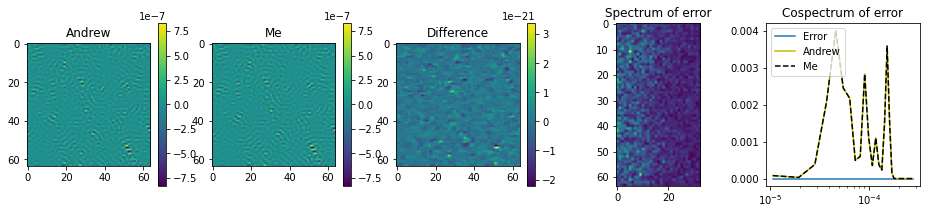

In [92]:
err1 = plot_fluxes(ppb.Operator1, op.Operator1)

mean Andrew = 4.0303533705237803e-10, mean Me = 4.0303533705236914e-10
Relative error = 2.6875899108261686e-29


INFO:  Logger initialized


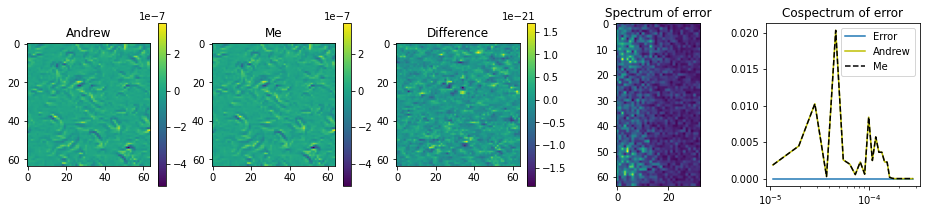

In [93]:
err2 = plot_fluxes(ppb.Operator2, op.Operator2)

INFO:  Logger initialized


mean Andrew = 2.0626930682802297e-10, mean Me = 2.0626930682801705e-10
Relative error = 2.3014723053966742e-30


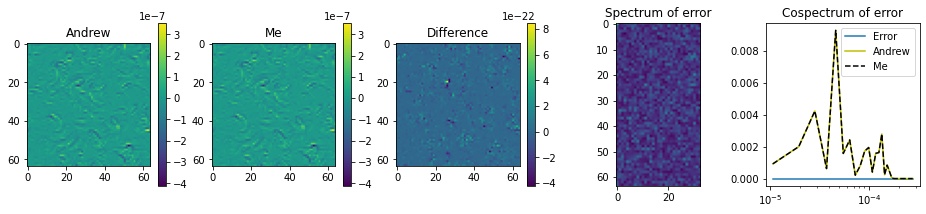

In [94]:
err3 = plot_fluxes(ppb.Operator3, op.Operator3)

# Computation of subgrid forcing

In [97]:
def plot_forces(opAndrew, opMe):
    Andrew = -opAndrew(m, 64).subgrid_forcing('q')[1]
    Me = op.PV_subgrid_forcing(q.values, 64, opMe, {})[0][1]
    qf = op.Operator3(q, 64)[1]
    return plot_error(Andrew, Me, qf)

INFO:  Logger initialized


mean Andrew = -4.338734978715565e-30, mean Me = 1.75028513345912e-30
Relative error = 1.028163214287079e-28


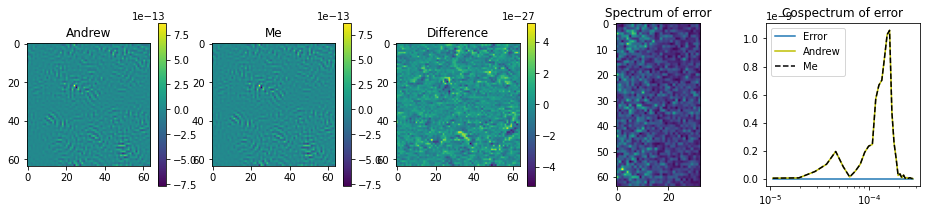

In [98]:
err1 = plot_forces(ppb.Operator1, op.Operator1)

INFO:  Logger initialized


mean Andrew = -1.5777218104420236e-30, mean Me = -7.888609052210118e-31
Relative error = 1.4176245925288896e-28


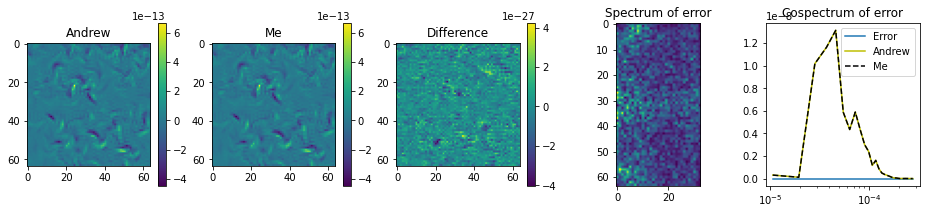

In [99]:
err2 = plot_forces(ppb.Operator2, op.Operator2)

INFO:  Logger initialized


mean Andrew = 2.3419308123748788e-30, mean Me = 1.035379938102578e-30
Relative error = 5.7682598225525594e-30


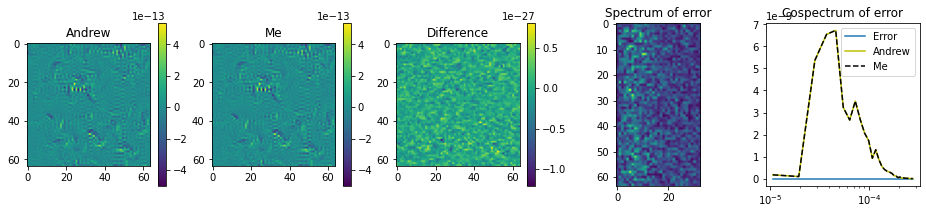

In [100]:
err3 = plot_forces(ppb.Operator3, op.Operator3)

# Commutation errors between subgrid and subfilter fluxes

In [101]:
def plot_commutation(opAndrew, opMe):
    qf = op.Operator3(q, 64)[0]
    
    forcing = -opAndrew(m, 64).subgrid_forcing('q')[0]
    flux = - op.divergence(*opAndrew(m, 64).subgrid_fluxes('q'))[0]
    plot_error(forcing, flux, qf, labels=('forcing', 'flux'))
    plt.suptitle('Andrew code', y=1.05)
    
    forcing = op.PV_subgrid_forcing(q.values, 64, opMe, {})[0][0]
    flux = op.divergence(*op.PV_subgrid_flux(q.values, 64, opMe, {}))[0]
    plot_error(forcing, flux, qf, labels=('forcing', 'flux'))
    plt.suptitle('My code', y=1.05)
    
    Andrew = - op.divergence(*opAndrew(m, 64).subgrid_fluxes('q'))[0]
    Me = op.divergence(*op.PV_subgrid_flux(q.values, 64, opMe, {}))[0]
    plot_error(Andrew, Me, qf)
    plt.suptitle('Andrew code cs mine', y=1.05)

INFO:  Logger initialized


mean Andrew = -6.547545513334398e-29, mean Me = -1.9721522630525295e-29
Relative error = 8.225666529169958e-30
mean Andrew = -5.443140246024981e-29, mean Me = 5.679798517591285e-29
Relative error = 1.0429826529164529e-29


INFO:  Logger initialized
INFO:  Logger initialized


mean Andrew = -1.9721522630525295e-29, mean Me = 5.679798517591285e-29
Relative error = 2.3556946490899053e-29


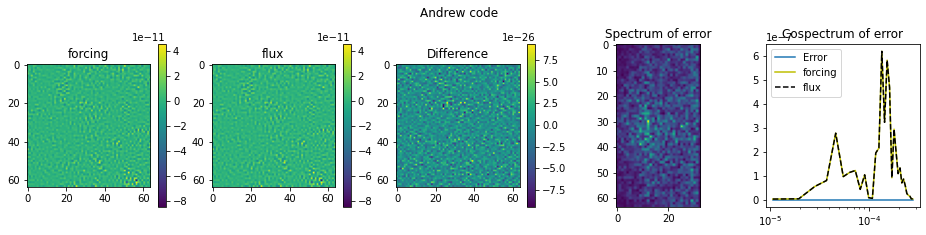

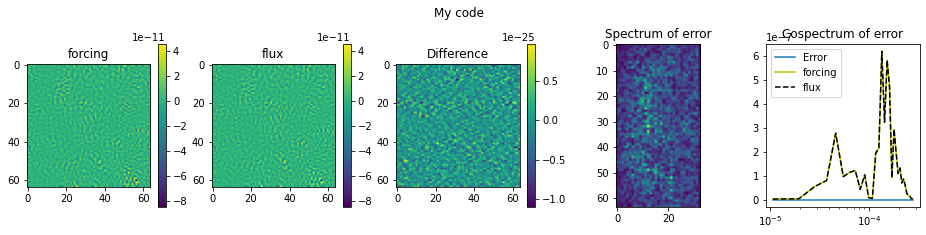

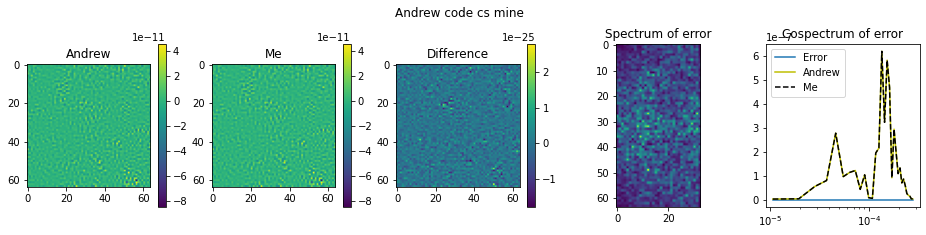

In [102]:
plot_commutation(ppb.Operator1, op.Operator1)

INFO:  Logger initialized


mean Andrew = 1.262177448353619e-29, mean Me = 8.67746995743113e-30
Relative error = 0.003018817199409331


INFO:  Logger initialized


mean Andrew = 1.0965166582572064e-28, mean Me = -2.0510383535746307e-29
Relative error = 0.0030188171994093354
mean Andrew = 8.67746995743113e-30, mean Me = -2.0510383535746307e-29
Relative error = 5.06629069657217e-29


INFO:  Logger initialized


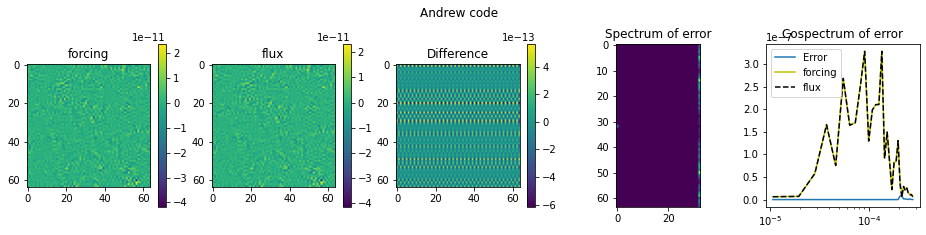

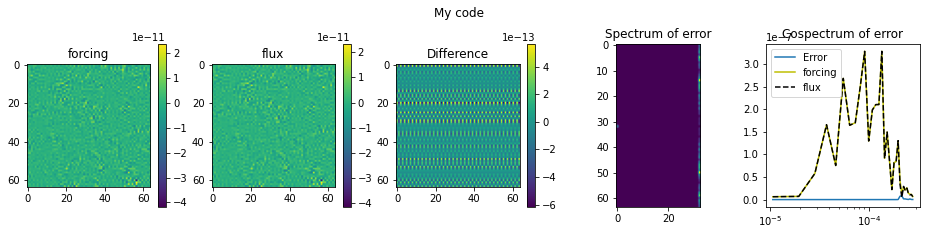

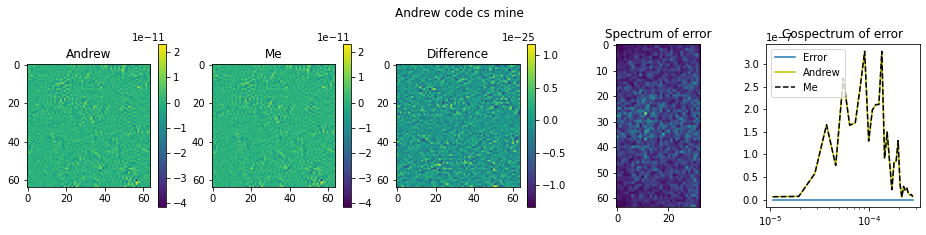

In [103]:
plot_commutation(ppb.Operator2, op.Operator2)

INFO:  Logger initialized


mean Andrew = 2.0510383535746307e-29, mean Me = 7.888609052210118e-31
Relative error = 0.6068221394889677
mean Andrew = -3.3526588471893e-29, mean Me = 7.888609052210118e-30
Relative error = 0.6068221394889677


INFO:  Logger initialized
INFO:  Logger initialized


mean Andrew = 7.888609052210118e-31, mean Me = 7.888609052210118e-30
Relative error = 3.612976130644191e-30


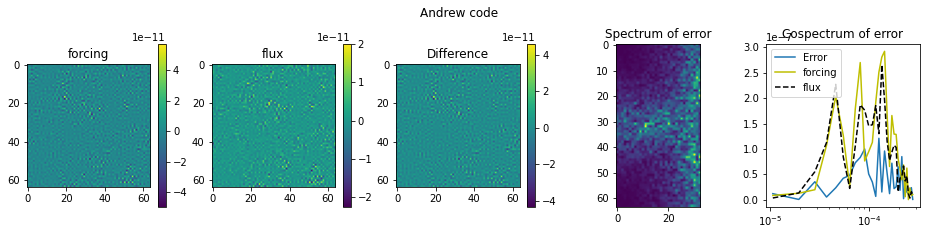

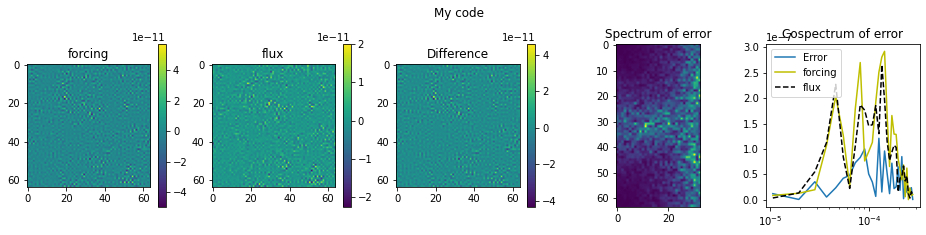

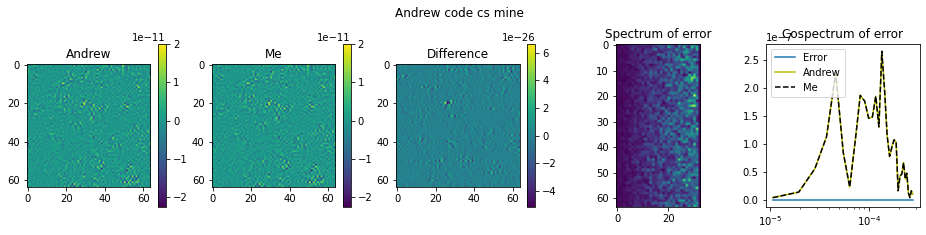

In [104]:
plot_commutation(ppb.Operator3, op.Operator3)

# Is there difference between total forcing and advection forcing?

In [195]:
def plot_advection_total(opAndrew, opMe):
    qf = op.Operator3(q, 64)[0]
    
    advection = -opAndrew(m, 64).subgrid_forcing('q')[0]
    total = opAndrew(m, 64).q_forcing_total[0]
    plot_error(advection, total, qf, labels=('advection', 'total'))
    plt.suptitle('Andrew code', y=1.05)
    
    advection = op.PV_subgrid_forcing(q.values, 64, opMe, {})[0]
    total = op.PV_forcing_total(q.values, 64, opMe, {})[0]
    plot_error(advection, total, qf, labels=('advection', 'total'))
    plt.suptitle('My code', y=1.05)
    
    Andrew = opAndrew(m, 64).q_forcing_total[0]
    Me = op.PV_forcing_total(q.values, 64, opMe, {})[0]
    plot_error(Andrew, Me, qf)
    plt.suptitle('Andrew code vs mine', y=1.05)

INFO:  Logger initialized


mean Andrew = 1.8932661725304283e-29, mean Me = 2.129924444096732e-29
Relative error = 3.7321201731940926e-30


INFO:  Logger initialized


mean Andrew = -1.9484864358958992e-28, mean Me = -1.199068575935938e-28
Relative error = 4.6659658779232766e-30
mean Andrew = 2.129924444096732e-29, mean Me = -1.199068575935938e-28
Relative error = 2.079551417857689e-29


INFO:  Logger initialized


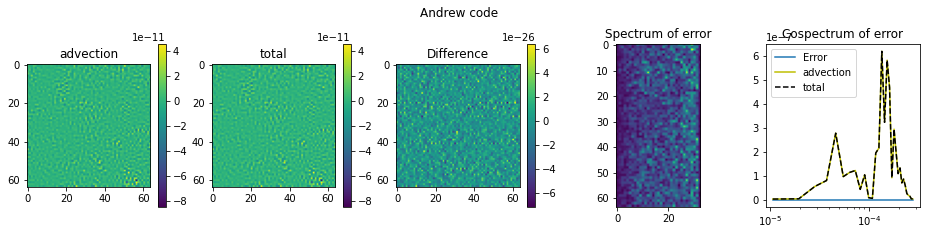

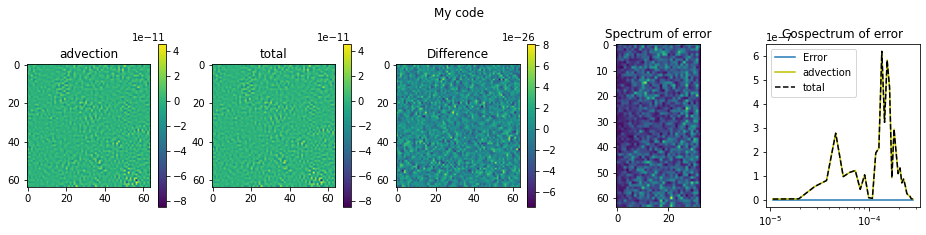

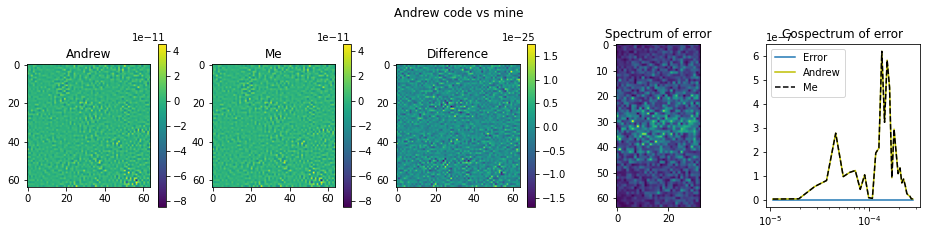

In [196]:
plot_advection_total(ppb.Operator1, op.Operator1)

INFO:  Logger initialized


mean Andrew = 2.3665827156630354e-29, mean Me = 8.204153414298523e-29
Relative error = 0.0012553256473551713


INFO:  Logger initialized


mean Andrew = -3.155443620884047e-29, mean Me = -7.178634237511207e-29
Relative error = 0.00125532564735517
mean Andrew = 8.204153414298523e-29, mean Me = -7.178634237511207e-29
Relative error = 4.715711235264399e-29


INFO:  Logger initialized


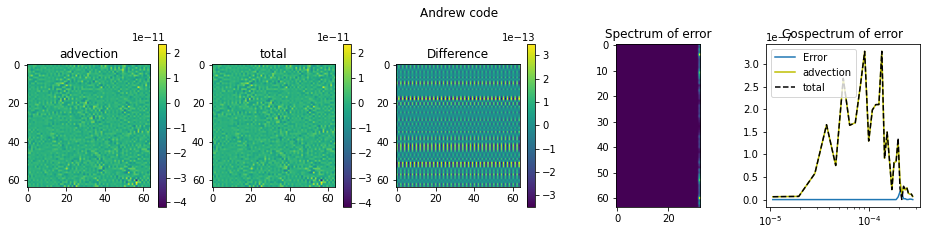

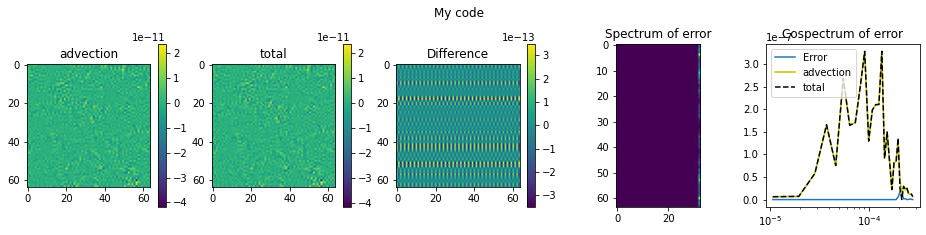

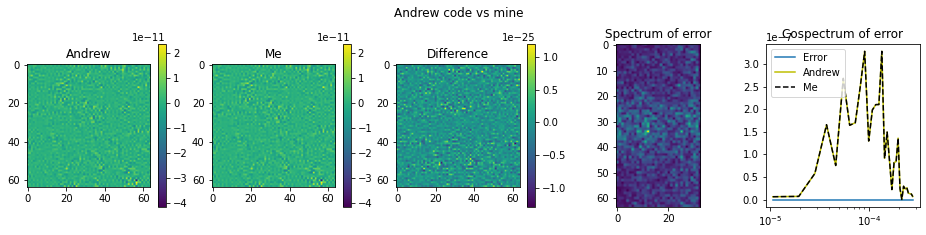

In [197]:
plot_advection_total(ppb.Operator2, op.Operator2)

INFO:  Logger initialized


mean Andrew = -4.9698237028923744e-29, mean Me = -4.614836295542919e-29
Relative error = 0.10261356691233742


INFO:  Logger initialized


mean Andrew = -6.03478592494074e-29, mean Me = -4.614836295542919e-29
Relative error = 0.10261356691233739


INFO:  Logger initialized


mean Andrew = -4.614836295542919e-29, mean Me = -4.614836295542919e-29
Relative error = 0.0


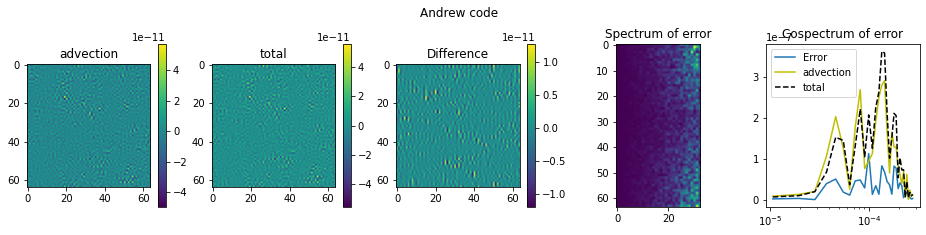

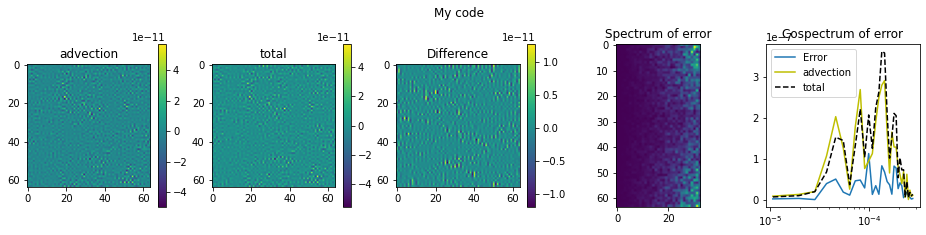

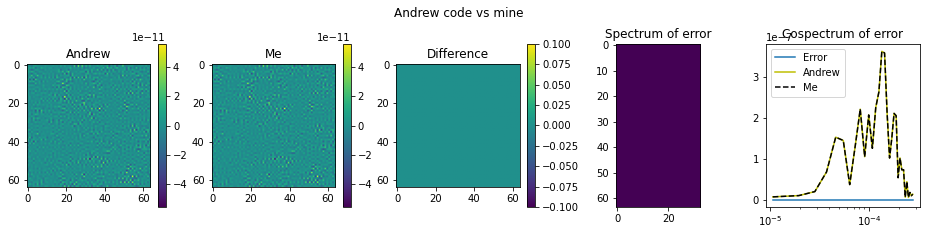

In [198]:
plot_advection_total(ppb.Operator3, op.Operator3)

# True total subgrid forcing

In [201]:
def plot_advection_true_total(opMe):
    qf = op.Operator3(q, 64)[0]
    
    total = op.PV_forcing_total(q.values, 64, opMe, {})[0]
    total_true = op.PV_forcing_true_total(q.values, 64, opMe, {})[0]
    plot_error(total, total_true, qf, labels=('total', 'true total'))
    plt.yscale('log')

INFO:  Logger initialized


mean Andrew = -1.199068575935938e-28, mean Me = 1.2249432136271871e-26
Relative error = 17.017392045413565


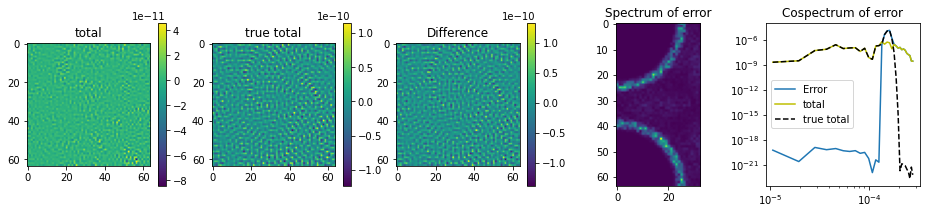

In [202]:
plot_advection_true_total(op.Operator1)

mean Andrew = -7.178634237511207e-29, mean Me = 1.520292736541934e-26
Relative error = 234.4097335353645


INFO:  Logger initialized


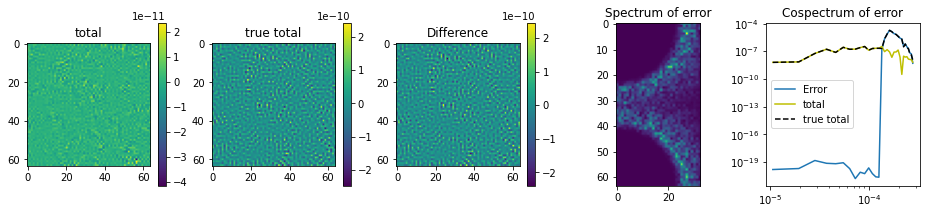

In [203]:
plot_advection_true_total(op.Operator2)

INFO:  Logger initialized


mean Andrew = -4.614836295542919e-29, mean Me = 1.1145026868962455e-26
Relative error = 192.39276626345028


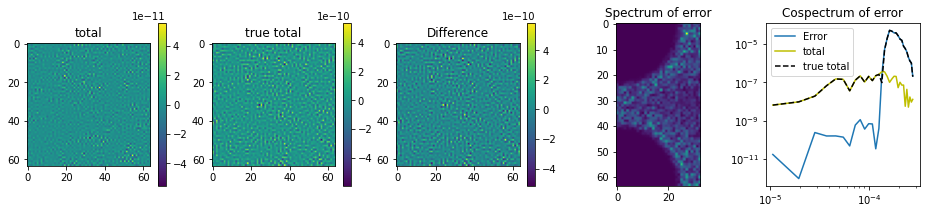

In [204]:
plot_advection_true_total(op.Operator3)

### Note: pyqg_subgrid_experiments do essentially the same, i.e. save time tendency 

# Subgrid forcing at various resolutions of DNS

In [205]:
def plot_different_DNS_resolution(opMe):
    qf = op.Operator3(q, 64)[0]
    
    forcing = op.PV_subgrid_forcing(q.values, 64, opMe, {})[0]
    q1 = op.cut_off(q.values, 128)
    forcing1 = op.PV_subgrid_forcing(q1, 64, opMe, {})[0]
    plot_error(forcing, forcing1, qf, labels=('DNS data', 'DNS $128^2$ data'))

INFO:  Logger initialized


mean Andrew = -1.9484864358958992e-28, mean Me = 3.865418435582958e-29
Relative error = 0.0002912715099227227


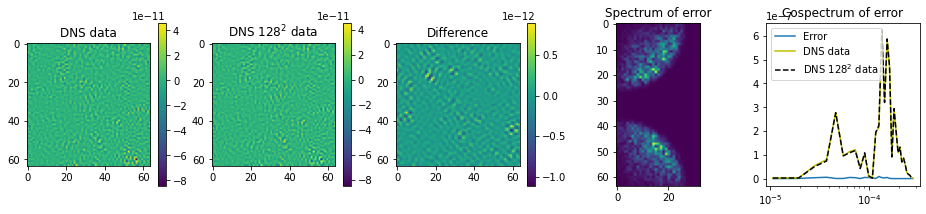

In [206]:
plot_different_DNS_resolution(op.Operator1)

INFO:  Logger initialized


mean Andrew = -3.155443620884047e-29, mean Me = -2.524354896707238e-29
Relative error = 0.0010126639237267206


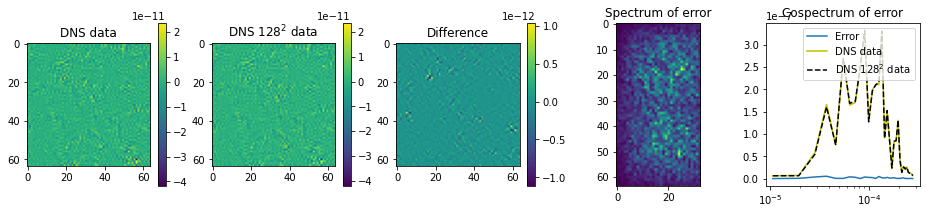

In [207]:
plot_different_DNS_resolution(op.Operator2)

INFO:  Logger initialized


mean Andrew = -6.03478592494074e-29, mean Me = 1.0255191767873153e-28
Relative error = 0.3474342682873744


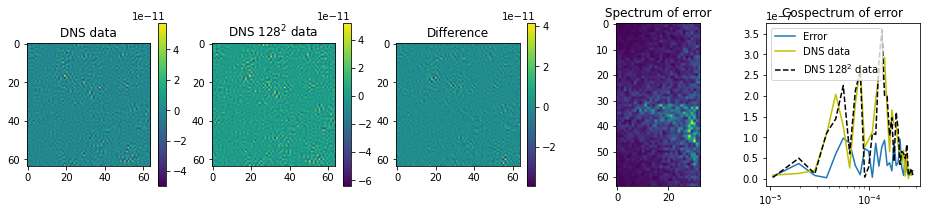

In [208]:
plot_different_DNS_resolution(op.Operator3)

# Subgrid forcing at various resolution of coarse model

In [53]:
def plot_different_coarse_resolution(opMe, *ncs):
    plt.figure(figsize=(12,6))
    for j, nc in enumerate(ncs):
        plt.subplot(2,len(ncs),j+1)
        forcing = op.PV_subgrid_forcing(q.values, nc, opMe, {})
        plt.imshow(forcing[0][0]); plt.title(f'(Upper), {nc}'); plt.colorbar()
        
        plt.subplot(2,len(ncs),j+1+len(ncs))
        forcing = op.PV_subgrid_forcing(q.values, nc, opMe, {})
        plt.imshow(forcing[0][1]); plt.title(f'(Lower), {nc}'); plt.colorbar()

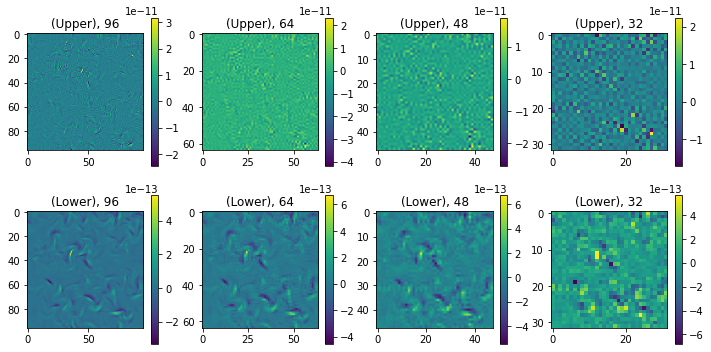

In [258]:
plot_different_coarse_resolution(op.Operator2, 96, 64, 48, 32)

# Gaussian noise as initial condition

INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized
INFO:  Logger initialized


4.384505333096387e-07
-5.88217324482153e-24


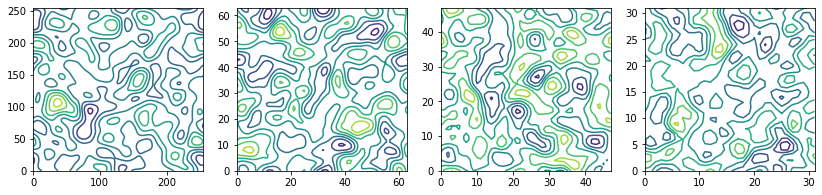

In [86]:
plt.figure(figsize=(14,3))
plt.subplot(1,4,1);plt.contour(pyqg.QGModel(nx=256).gaussian_field())
plt.subplot(1,4,2);plt.contour(pyqg.QGModel(nx=64).gaussian_field())
plt.subplot(1,4,3);plt.contour(pyqg.QGModel(nx=48).gaussian_field())
plt.subplot(1,4,4);plt.contour(pyqg.QGModel(nx=32).gaussian_field())
print(pyqg.QGModel(nx=48).gaussian_field().std())
print(pyqg.QGModel(nx=48).gaussian_field().mean())

In [434]:
m = pyqg.QGModel(tmax=86400*360*10, twrite=10000)
ds = []
for t in m.run_with_snapshots(tsnapint=1000*3600):
    ds.append(m.to_dataset())
old_noise = xr.concat(ds, dim='time')

INFO:  Logger initialized
INFO: Step: 10000, Time: 7.20e+07, KE: 2.96e-04, CFL: 0.074
INFO: Step: 20000, Time: 1.44e+08, KE: 5.05e-04, CFL: 0.092
INFO: Step: 30000, Time: 2.16e+08, KE: 4.68e-04, CFL: 0.103
INFO: Step: 40000, Time: 2.88e+08, KE: 5.72e-04, CFL: 0.101


In [435]:
m = pyqg.QGModel(tmax=86400*360*10, twrite=10000)
m.set_q1q2(m.gaussian_field(), 0*m.x)
ds = []
for t in m.run_with_snapshots(tsnapint=1000*3600):
    ds.append(m.to_dataset())
new_noise = xr.concat(ds, dim='time')

INFO:  Logger initialized
INFO: Step: 10000, Time: 7.20e+07, KE: 2.25e-04, CFL: 0.073
INFO: Step: 20000, Time: 1.44e+08, KE: 5.36e-04, CFL: 0.098
INFO: Step: 30000, Time: 2.16e+08, KE: 4.68e-04, CFL: 0.095
INFO: Step: 40000, Time: 2.88e+08, KE: 5.05e-04, CFL: 0.112


In [436]:
def KE(dataset):
    return (op.ave_lev((dataset.u**2 + dataset.v**2)*0.5, 0.25)).mean(dim=('x','y'))

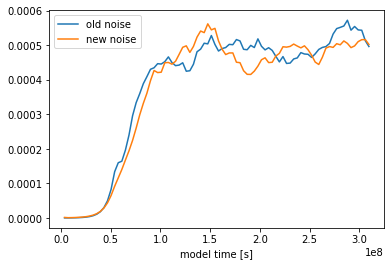

In [437]:
KE(old_noise).plot(label='old noise')
KE(new_noise).plot(label='new noise')
plt.legend()

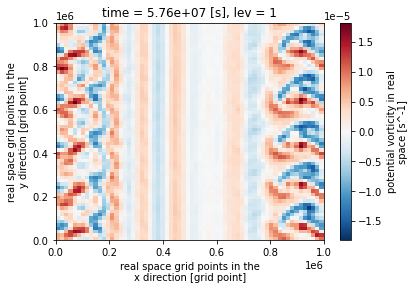

In [438]:
old_noise.q.isel(time=15, lev=0).plot()

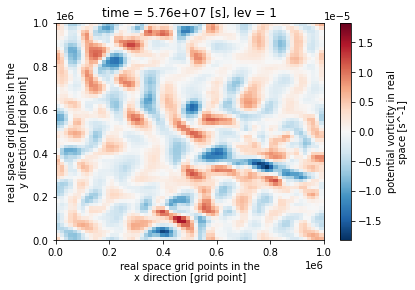

In [439]:
new_noise.q.isel(time=15,lev=0).plot()

In [456]:
m = pyqg.QGModel(tmax=86400*30)
m.q.mean(axis=(1,2))
for t in m.run_with_snapshots():
    print(m.q.mean(axis=(1,2)))

INFO:  Logger initialized


[3.30872245e-24 0.00000000e+00]
[3.30872245e-24 0.00000000e+00]
[-3.30872245e-24 -4.13590306e-25]
[3.30872245e-24 0.00000000e+00]
[ 0.00000000e+00 -8.27180613e-25]
[-3.30872245e-24  0.00000000e+00]


# Generation of subgrid forces

In [1]:
from pyqg_generative.tools.simulate import generate_subgrid_forcing
from pyqg_generative.tools.operators import ave_lev
%load_ext autoreload
%autoreload 3

In [214]:
out = generate_subgrid_forcing(128, [32, 48, 64, 96], {'tmax': 1000*3600*4})

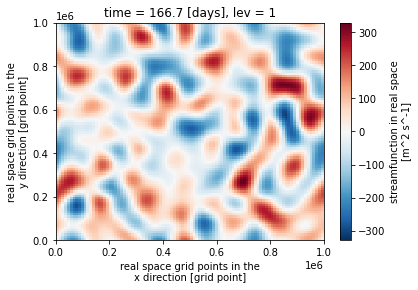

In [215]:
out['Operator2-96'].psi.isel(lev=0, time=-1).plot()

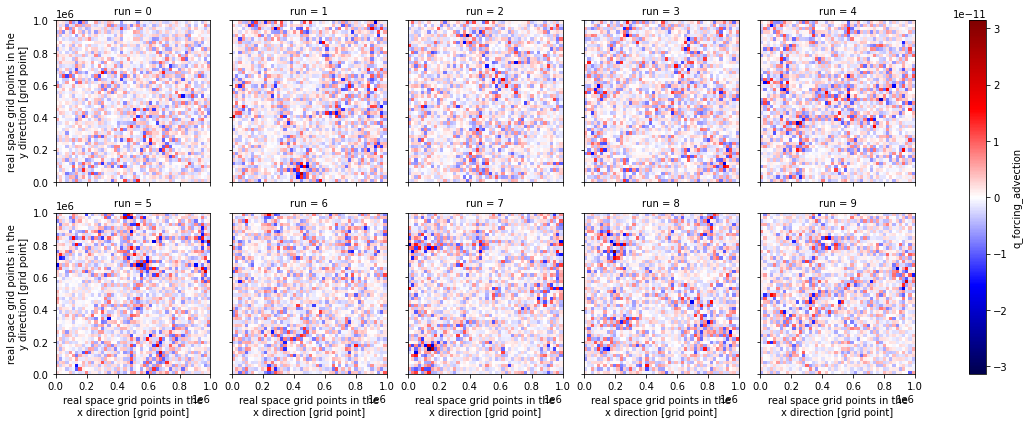

In [221]:
ds.q_forcing_advection.isel(time=-1,lev=0, run=slice(0,10)).plot(col='run', col_wrap=5, cmap='seismic')

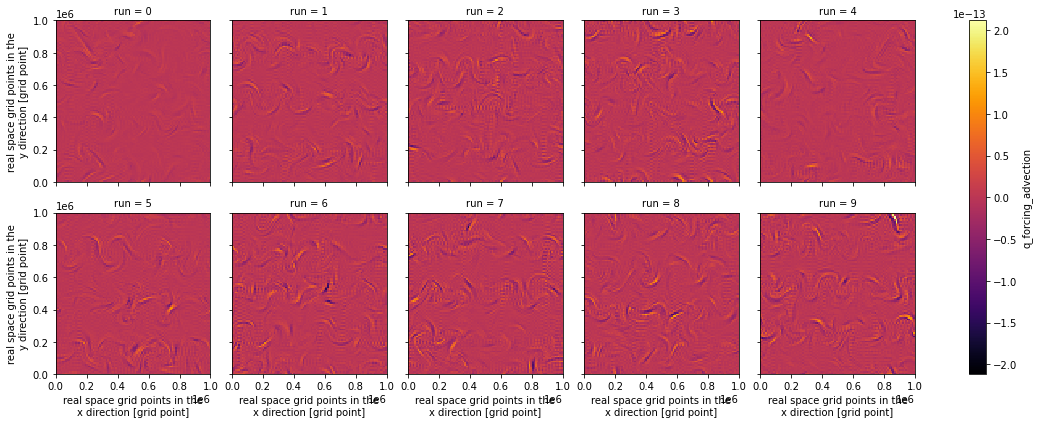

In [222]:
ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white/jet/Operator2-96/[0-9].nc', combine='nested', concat_dim='run')
ds.q_forcing_advection.isel(time=-1,lev=1, run=slice(0,10)).plot(col='run', col_wrap=5, cmap='inferno')

Operator1-32
Operator1-48
Operator1-64
Operator1-96


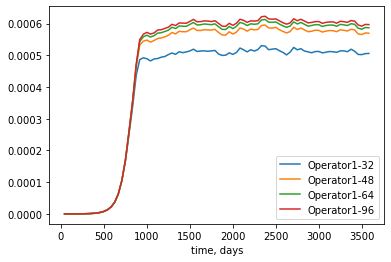

In [223]:
for folder in ['Operator1-32', 'Operator1-48', 'Operator1-64', 'Operator1-96']:
    ds = xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/SGS_forces_white/eddy/{folder}/[0-9].nc', combine='nested', concat_dim='run')
    ds['time'] = ds.time.dt.days
    ds['time'].attrs['long_name'] = 'time, days'
    KE = (ave_lev(ds.u**2 + ds.v**2, 0.25)*0.5).mean(dim=('run', 'x', 'y'))
    KE.plot(label=folder)
    print(folder)
plt.legend()

Operator2-32
Operator2-48
Operator2-64
Operator2-96


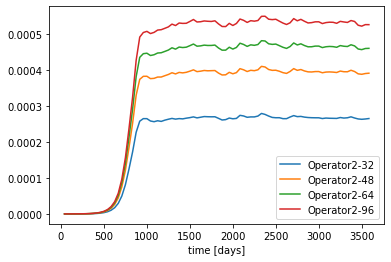

In [224]:
for folder in ['Operator2-32', 'Operator2-48', 'Operator2-64', 'Operator2-96']:
    ds = xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/SGS_forces_white/eddy/{folder}/[0-9].nc', combine='nested', concat_dim='run', decode_times=False)
    KE = (ave_lev(ds.u**2 + ds.v**2, 0.25)*0.5).mean(dim=('run', 'x', 'y'))
    KE.plot(label=folder)
    print(folder)
plt.legend()

Operator1-64


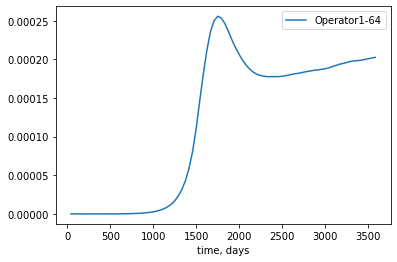

In [225]:
for folder in ['Operator1-64']:
    ds = xr.open_mfdataset(f'/scratch/pp2681/pyqg_generative/SGS_forces_white/jet/{folder}/*.nc', combine='nested', concat_dim='run')
    ds['time'] = ds.time.dt.days
    ds['time'].attrs['long_name'] = 'time, days'
    KE = (ave_lev(ds.u**2 + ds.v**2, 0.1)*0.5).mean(dim=('run', 'x', 'y'))
    KE.plot(label=folder)
    print(folder)
plt.legend()

# Reference simulations gaussian

In [13]:
def plot_dataset(ds, label):
    plt.subplot(1,2,1)
    ave_lev(spectrum(averaging=True)(ds.u)+spectrum(averaging=True)(ds.v),ds.attrs['pyqg:delta']).plot(label=label, xscale='log', yscale='log')
    plt.title('Kinetic energy spectrum')
    plt.ylim([1e-2, 1e+2])
    plt.legend()
    plt.subplot(1,2,2)
    KE = (ave_lev(ds.u**2 + ds.v**2, ds.attrs['pyqg:delta'])*0.5).mean(dim=('run', 'x', 'y'))
    KE.plot(label=label)
    plt.title('Kinetic energy')

(0.05, 100.0)

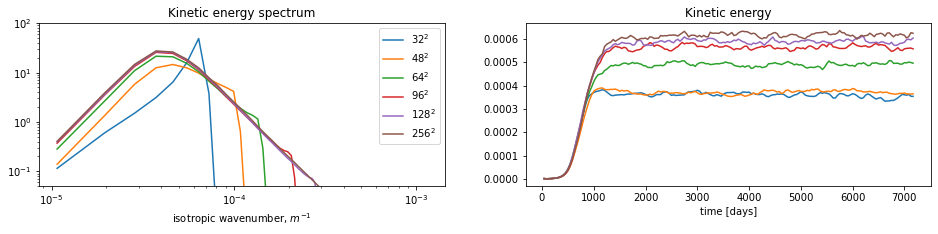

In [218]:
plt.figure(figsize=(16,3))

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces/eddy/reference_32/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$32^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces/eddy/reference_48/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$48^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces/eddy/reference_64/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$64^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces/eddy/reference_96/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$96^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces/eddy/reference_128/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$128^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces/eddy/reference_256/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$256^2$')

plt.subplot(1,2,1)
plt.ylim([5e-2, 1e+2])

(0.01, 30.0)

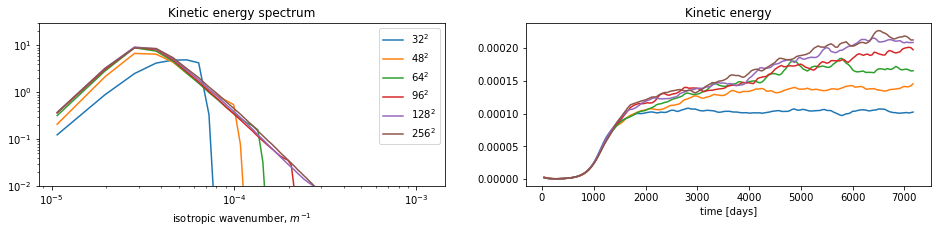

In [219]:
plt.figure(figsize=(16,3))
ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces/jet/reference_32/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$32^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces/jet/reference_48/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$48^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces/jet/reference_64/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$64^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces/jet/reference_96/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$96^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces/jet/reference_128/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$128^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces/jet/reference_256/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$256^2$')

plt.subplot(1,2,1)
plt.ylim([1e-2, 3e+1])

# White noise dataset

(0.05, 100.0)

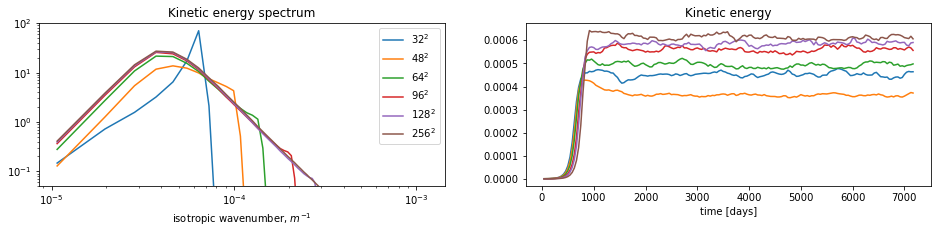

In [217]:
plt.figure(figsize=(16,3))
ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white/eddy/reference_32/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$32^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white/eddy/reference_48/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$48^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white/eddy/reference_64/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$64^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white/eddy/reference_96/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$96^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white/eddy/reference_128/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$128^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white/eddy/reference_256/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$256^2$')

plt.subplot(1,2,1)
plt.ylim([5e-2, 1e+2])

(0.01, 30.0)

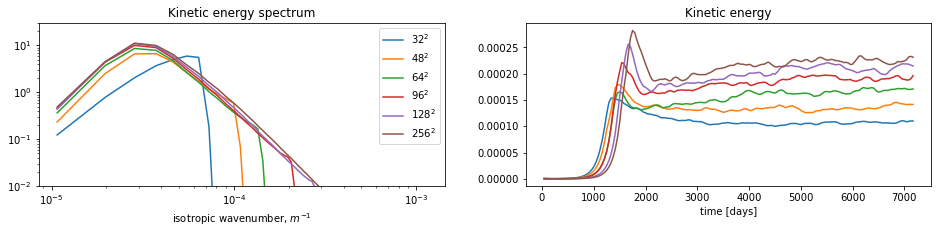

In [216]:
plt.figure(figsize=(16,3))
ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white/jet/reference_32/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$32^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white/jet/reference_48/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$48^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white/jet/reference_64/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$64^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white/jet/reference_96/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$96^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white/jet/reference_128/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$128^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white/jet/reference_256/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$256^2$')

plt.subplot(1,2,1)
plt.ylim([1e-2, 3e+1])

# White noise scaled dataset

(0.05, 100.0)

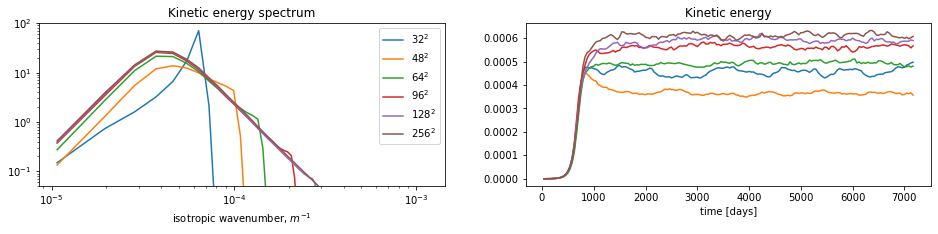

In [14]:
plt.figure(figsize=(16,3))
ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white_scaled/eddy/reference_32/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$32^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white_scaled/eddy/reference_48/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$48^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white_scaled/eddy/reference_64/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$64^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white_scaled/eddy/reference_96/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$96^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white_scaled/eddy/reference_128/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$128^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white_scaled/eddy/reference_256/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$256^2$')

plt.subplot(1,2,1)
plt.ylim([5e-2, 1e+2])

(0.001, 20.0)

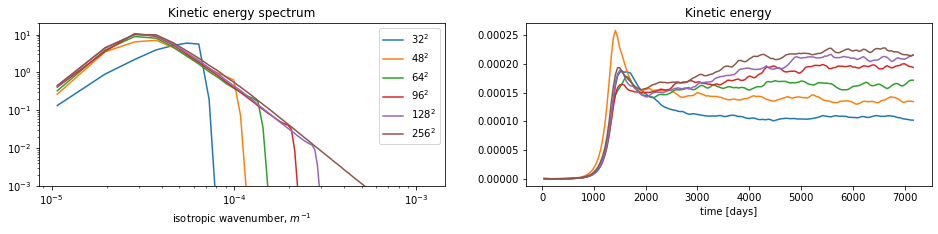

In [17]:
plt.figure(figsize=(16,3))
ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white_scaled/jet/reference_32/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$32^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white_scaled/jet/reference_48/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$48^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white_scaled/jet/reference_64/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$64^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white_scaled/jet/reference_96/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$96^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white_scaled/jet/reference_128/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$128^2$')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white_scaled/jet/reference_256/*', combine='nested', concat_dim='run', decode_times=False)
plot_dataset(ds, '$256^2$')

plt.subplot(1,2,1)
plt.ylim([1e-3, 2e+1])

# Growth of initial disturbances

# Unscaled white noise dataset

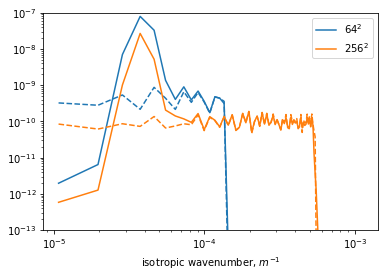

In [171]:
ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white/jet/reference_64/*', combine='nested', concat_dim='run', decode_times=False)
line = spectrum(time=slice(0,1))(ds.q).sum('lev').plot(yscale='log', xscale='log', ls='--')
spectrum(time=slice(20,21))(ds.q).sum('lev').plot(yscale='log', xscale='log', color=line[0]._color, label='$64^2$')
plt.ylim([1e-13, 1e-7])

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white/jet/reference_256/*', combine='nested', concat_dim='run', decode_times=False)
line = spectrum(time=slice(0,1))(ds.q).sum('lev').plot(yscale='log', xscale='log', ls='--')
spectrum(time=slice(20,21))(ds.q).sum('lev').plot(yscale='log', xscale='log', color=line[0]._color, label='$256^2$')
plt.ylim([1e-13, 1e-7])

plt.legend()

# Gaussian dataset

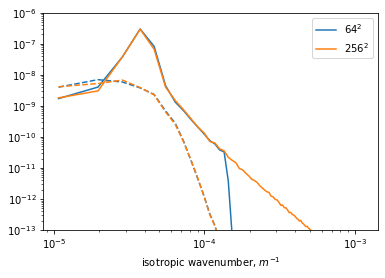

In [173]:
ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces/jet/reference_64/*', combine='nested', concat_dim='run', decode_times=False)
line = spectrum(time=slice(0,1))(ds.q).sum('lev').plot(yscale='log', xscale='log', ls='--')
spectrum(time=slice(20,21))(ds.q).sum('lev').plot(yscale='log', xscale='log', color=line[0]._color, label='$64^2$')
plt.ylim([1e-13, 1e-7])

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces/jet/reference_256/*', combine='nested', concat_dim='run', decode_times=False)
line = spectrum(time=slice(0,1))(ds.q).sum('lev').plot(yscale='log', xscale='log', ls='--')
spectrum(time=slice(20,21))(ds.q).sum('lev').plot(yscale='log', xscale='log', color=line[0]._color, label='$256^2$')
plt.ylim([1e-13, 1e-6])

plt.legend()

# White scaled

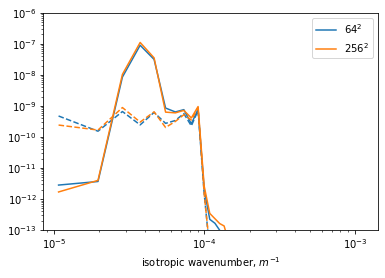

In [11]:
ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white_scaled/jet/reference_64/*', combine='nested', concat_dim='run', decode_times=False)
line = spectrum(time=slice(0,1))(ds.q).sum('lev').plot(yscale='log', xscale='log', ls='--')
spectrum(time=slice(20,21))(ds.q).sum('lev').plot(yscale='log', xscale='log', color=line[0]._color, label='$64^2$')
plt.ylim([1e-13, 1e-7])

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white_scaled/jet/reference_256/*', combine='nested', concat_dim='run', decode_times=False)
line = spectrum(time=slice(0,1))(ds.q).sum('lev').plot(yscale='log', xscale='log', ls='--')
spectrum(time=slice(20,21))(ds.q).sum('lev').plot(yscale='log', xscale='log', color=line[0]._color, label='$256^2$')
plt.ylim([1e-13, 1e-6])

plt.legend()

# Scaled to unscaled at default 64 resolution

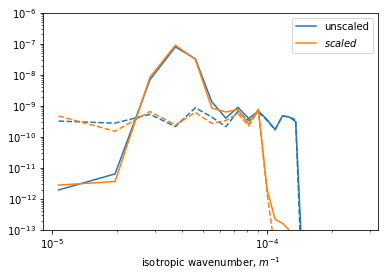

In [10]:
ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white/jet/reference_64/*', combine='nested', concat_dim='run', decode_times=False)
line = spectrum(time=slice(0,1))(ds.q).sum('lev').plot(yscale='log', xscale='log', ls='--')
spectrum(time=slice(20,21))(ds.q).sum('lev').plot(yscale='log', xscale='log', color=line[0]._color, label='unscaled')

ds = xr.open_mfdataset('/scratch/pp2681/pyqg_generative/SGS_forces_white_scaled/jet/reference_64/*', combine='nested', concat_dim='run', decode_times=False)
line = spectrum(time=slice(0,1))(ds.q).sum('lev').plot(yscale='log', xscale='log', ls='--')
spectrum(time=slice(20,21))(ds.q).sum('lev').plot(yscale='log', xscale='log', color=line[0]._color, label='$scaled$')
plt.ylim([1e-13, 1e-6])
plt.legend()